# Client info crucial for Bank marketing success prediction

## Section A: Introduction

This section has the background, business understanding, goals and objectives

## Overview:

In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.

## Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The data is related with direct PHONECALL marketing campaigns of a Portuguese banking institution trying to get clients make TERM DEPOSITS. 17 campaigns were done over a period of ~years. ~40000 campaign calls made which achieved ~10% success rate. The data has 10 numerical features and 11 categorical features.

## Section B: Libraries

This section has the needed python libraries and my customer defined AI/ML functions

### B1) Generic Libraries

In [1]:
# data structures
import pandas as pd
import numpy as np

# my folder path
from pathlib import Path
myfolder = Path("C:/Users/pdpc/Documents/MLfiles/Data/")
BerkAIdatafolder = Path("C:/Users/pdpc/Documents/MLfiles/Data/berkAIdata/")

# for timing program run
import time

# graphs
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

# train/test split
from sklearn.model_selection import train_test_split

# supress warning
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.exceptions import FitFailedWarning 

# code to overcome my system specific errors
# patch for overcoming 'float' error in nump 24.1v
np.float = float    
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'

# Classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# ColTransf / Pipeline / GridSearch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn.metrics import roc_auc_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

### B2) zSrv Sravan Katragadda custom Libraries

my custom defined functions I developed over my years for AI & ML problem solving

In [2]:
# zsrv function for quick data analyis

def data_snapshot(df):
    print('Quick Data Analysis')
    print("Dataset shape:  ",df.shape)
    print("Dataset size:   ",df.size)
    print("# of columns with numerical features  :   ",len(df.select_dtypes(include=['int64', 'float64']).columns.values))
    print("# of columns with categorical features:   ",len(df.select_dtypes(include=['object', 'category']).columns.values))
    
    num_features = list(df.select_dtypes(include=['int64', 'float64']).columns.values)
    cat_features = list(df.select_dtypes(include=['object', 'category','bool']).columns.values)
    #This is a check to see if any features are being missed out
    oth_features = list(set(df.columns.tolist()) - set(num_features) - set(cat_features))
    
    print('Numerical features:', num_features)
    print('Categorical features:', cat_features)
    print('non-num/non-cat features:', oth_features)
    print()
    
def info_df(df):
    
    # io module provides tools for working with text I/O, binary I/O, and raw I/O
    import io
    # Create a buffer to capture the output of df.info()
    buffer = io.StringIO()
    df.info(buf=buffer)
    s = buffer.getvalue()
    # Parse the captured text into a DataFrame
    info_lines = s.split('\n')
    info_data = [line.split(maxsplit=4) for line in info_lines[5:-3]]
    columns = ['#', 'column', '# of non-nulls', 'non-null', 'Data Type']
    info_df = pd.DataFrame(info_data, columns=columns)
    
    
    info_df['# of non-nulls'] = info_df['# of non-nulls'].astype('int64')
    s = df.shape[0]
    info_df['# of nulls'] = s - info_df['# of non-nulls']
    info_df['% of nulls'] = round((info_df['# of nulls'] / s * 100),1)
    
    info_df = info_df.reset_index()
    info_df.index = range(1, len(info_df) + 1)
    info_df = info_df[['column','Data Type','# of nulls','% of nulls']]
    
    return(info_df)

# zsrv function for getting null values information

def nulls_info(df):    

    # getting df with null info
    datasetsize = df.shape[0]
    df_nullinfo = pd.DataFrame(df.isna().sum(),columns=['# of Null Values'])
    df_nullinfo['% of Null Values'] = (df_nullinfo['# of Null Values'] / datasetsize * 100).round(1)
    return df_nullinfo

# --------------------------------------------------------------------------------------------------

def nulls_remove(df):
    
    pre_size = df.shape[0]
    # Removing rows with null values
    df.dropna(inplace=True)
    post_size = df.shape[0]
    print('Data loss in removing nulls:', "%.2f" % (100-(post_size / pre_size * 100)) , '%')
    return df

# --------------------------------------------------------------------------------------------------

def nulls_impute(df):
    
    num_features = list(df.select_dtypes(include=['int64', 'float64']).columns.values)
    cat_features = list(df.select_dtypes(include=['object', 'category','bool']).columns.values)
    print(f'There are {len(num_features)} numerical features and {len(cat_features)} categorical features in {datasetname} dataset')
    # Define imputers
    numerical_imputer = SimpleImputer(strategy='mean')
    categorical_imputer = SimpleImputer(strategy='constant',fill_value='missing')
    # Numerical Values Imputation
    df[num_features] = numerical_imputer.fit_transform(df[num_features])
    # Categorical Values Imputation
    df[cat_features] = categorical_imputer.fit_transform(df[cat_features])
    # return df
    return df

def IQRoutliers_info(df):
    
    # get Data Loss %
    '''df1 = df
    pre_size = df1.shape[0]
    
    for col in df1.select_dtypes(include=['float64', 'int64']).columns.tolist():
        q1 = df1[col].quantile(0.25)
        q3 = df1[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df1 = df1[(df1[col] >= lower_bound) & (df1[col] <= upper_bound)]
    
    post_size = df1.shape[0]
    print('Data loss in removing nulls:', "%.2f" % (100-(post_size / pre_size * 100)) , '%')
    '''
    
    # get only numerical columns
    df = df.select_dtypes(include=['number'])
    
    # getting df with outlier info
    datasetsize = df.shape[0]
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_IQRoutliersinfo = pd.DataFrame(((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum(),columns=['# of Outliers'])
    df_IQRoutliersinfo['% Outliers'] = (df_IQRoutliersinfo['# of Outliers'] / datasetsize * 100).round(1)
    return df_IQRoutliersinfo

def IQRoutliers_remove(df):
    
    # get Data Loss %
    pre_size = df.shape[0]
    
    for col in df.select_dtypes(include=['float64', 'int64']).columns.tolist():
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    post_size = df.shape[0]
    print('Data loss in removing IQQ outliers:', "%.2f" % (100-(post_size / pre_size * 100)) , '%')
    return df

# --------------------------------------------------------------------------------------------------

# zsrv function to get highly correlated features
def get_high_correlated_features(df):
    
    # Calculate the correlation matrix
    corr_matrix = df.corr()
    # Remove duplicate values and keep the upper triangle
    corr_matrix_upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Flatten the matrix and drop NA values (diagonal values)
    corrdf = corr_matrix_upper.stack().reset_index()
    corrdf.columns = ['Feature 1', 'Feature 2', 'PearsonCorrCoef']
    high_corrdf = corrdf[(corrdf['PearsonCorrCoef'] <= -0.7)]
    high_corrdf = corrdf[(corrdf['PearsonCorrCoef'] >= 0.7)]
    
    print(f'There are {len(high_corrdf)} feature combinations that are HIGHLY correlated by Pearson Correlation Coefficient')
    p = len(high_corrdf.query('PearsonCorrCoef > 0.7'))
    print(f'There are {p} feature combinations that are HIGHLY positively correlated by Pearson Correlation Coefficient')
    n = len(high_corrdf.query('PearsonCorrCoef < -0.7'))
    print(f'There are {n} feature combinations that are HIGHLY negatively correlated by Pearson Correlation Coefficient')
    
    return high_corrdf

# --------------------------------------------------------------------------------------------------
  
# My custom function for Preprocessing X

def preprocessX(A):
    
    # features
    num_all_features = list(A.select_dtypes(include=['int64', 'float64']).columns.values)
    cat_all_features = list(A.select_dtypes(include=['object', 'category','bool']).columns.values)

    # Numerical Transformation
    num_transform = Pipeline (steps=[
                    ('imp', SimpleImputer(strategy='median')),
                    ('mms', MinMaxScaler())
                    ])

    # Categorical Operations
    cat_transform = Pipeline (steps=[
                    ('imp', SimpleImputer(strategy='constant',fill_value='missing')),
                    ('ore', OrdinalEncoder())
                    ])

    # Column Transformer (CT)
    preprocessor = ColumnTransformer(transformers=[
                    ('num_tran', num_transform, num_all_features),
                    ('cat_tran', cat_transform, cat_all_features),
                    ])
    
    B = preprocessor.fit_transform(A)
    
    return(B)

# --------------------------------------------------------------------------------------------------


# my custom function for running multiple classifier models

def evalC(X,y):         
    
    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    models = [LogisticRegression(),
              KNeighborsClassifier(),
              GradientBoostingClassifier(),
              SVC(),
              DecisionTreeClassifier(),
              RandomForestClassifier(),
              AdaBoostClassifier(DecisionTreeClassifier()),
              ExtraTreesClassifier(),
              MLPClassifier(),
              LinearDiscriminantAnalysis()]
                   
    names  = ['LOG','KNN','GBC','SVC','DEC','RAF','ABC','ETC','MLP','LDA']

    precision = []
    recall = []
    f1 = []
    acc_train = []
    acc_test  = []
    
    for model,name in zip(models,names):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        precision_calc,recall_calc,f1score_calc,support_calc=score(y_test,y_pred,average='macro')
        precision.append("%.4f" % precision_calc)
        recall.append("%.4f" % recall_calc)
        f1.append("%.4f" % f1score_calc)
        
        acc_train.append("%.4f" % model.score(X_train, y_train))
        acc_test.append("%.4f" % model.score(X_test, y_test))  
                     
    # Getting results of Evaluation into a DF
    df_eval = pd.DataFrame({'precision':precision,'recall':recall,'f1':f1,'acc_train':acc_train,'acc_test':acc_test})
    df_eval = df_eval.T
    df_eval.columns = names
    return(df_eval)


# Visualizing Classses of Data in 2D using PCA

def visualize_classes_in_pca(X,y):
    
    scaled_X = preprocessX(X)
    LE = LabelEncoder()
    scaled_y = LE.fit_transform(y)
    z = LE.classes_

    pca = PCA(n_components=2)
    X_reducedfeatures = pca.fit_transform(scaled_X)

    # Plotting in PCA Dimensions
    plt.figure(figsize=(10,8))
    plt.scatter(X_reducedfeatures[:,0],X_reducedfeatures[:,1], s = 8, c=scaled_y, label=z)
    plt.xlabel('First principle component')
    plt.ylabel('Second principle component')
    plt.title('Classes Visualization in 2D-PCA')
    plt.legend()
    
    
    # Evaluating PCA
    print("Preserved variance is: ", "%.2f" % (np.sum(pca.explained_variance_ratio_) * 100),"%")
    print("PCA features:          ", pca.explained_variance_ratio_)

## Section C: Data

This section contains:

 1. Data Understanding, 
 2. Gets raw data
 3. Curates Columns
 4. Handles Duplicates
 5. Handles Outliers
 6. Handles Nulls
 7. Handles Special issues with data 

### C1) Data Understanding

## Problem 2: Read in the Data

Use pandas to read in the dataset bank-additional-full.csv and assign to a meaningful variable name.

## Problem 3: Understanding the Features

Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


The Data comprises of 3 components:

1) Client Data: personal and demographic data of the client who the campaign contacted

client: age

client: job

client: marital

client: education

client: default

client: housing

client: loan

2) Marketing Campaign information: mode of communication, frequency of communication, period of communication

mark: contact

mark: month

mark: contact day_of_week

mark: duration

mark: campaign

mark: pdays

mark: previous

mark: poutcome

3) Data pertaining to prevailing economic situation at the time of the campaign

eco: ecovarrate

eco: cpi

eco: confindex

eco: euribor3m

### C2) Raw data get

In [4]:
rawdata = pd.read_csv(BerkAIdatafolder / 'portugese bank data additional.csv')

datasetname = 'BankMarketing'

rawdata.head()

,y,age,job,marital,education,default,housing,loan,contact,month,...,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,N,56,housemaid,married,basic.4y,no,no,no,telephone,may,...,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,N,57,services,married,high.school,unknown,no,no,telephone,may,...,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,N,37,services,married,high.school,no,yes,no,telephone,may,...,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,N,40,admin.,married,basic.6y,no,no,no,telephone,may,...,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,N,56,services,married,high.school,no,no,yes,telephone,may,...,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


### C3) Raw data quick analysis

In [5]:
# my custom function for quick data analysis snapshot

data_snapshot(rawdata)

Quick Data Analysis
Dataset shape:   (41188, 21)
Dataset size:    864948
# of columns with numerical features  :    10
# of columns with categorical features:    11
Numerical features: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical features: ['y', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
non-num/non-cat features: []



In [6]:
# my custom function for looking at data types and nulls

info_df(rawdata)

,column,Data Type,# of nulls,% of nulls
1,y,object,0,0.0
2,age,int64,0,0.0
3,job,object,0,0.0
4,marital,object,0,0.0
5,education,object,0,0.0
6,default,object,0,0.0
7,housing,object,0,0.0
8,loan,object,0,0.0
9,contact,object,0,0.0
10,month,object,0,0.0


### C4) Columns curation

Here only columns will be modified and there will be no change to rows.

 1. drop irrelevant columns 
 2. column names handling
 3. columns sort

End product is neat meaningful columns.

In [10]:
data = rawdata

data = rawdata

# 1) removing obviously irrelevant columns
drop_col = []
data = data.drop(drop_col, axis=1, errors='ignore')

# 2) column names handling - rename, case handling
data.columns = data.columns.str.lower()
rename_dict = {'y':'ClientResponse','age':'client: age', 'job':'client: job', 'marital':'client: marital', 'education':'client: education',
               'default':'client: default', 'housing':'client: housing', 'loan':'client: loan', 
               'contact':'mark:contact', 'month':'mark:month', 'day_of_week':'mark:contact day_of_week', 'duration':'mark:duration',
               'campaign':'mark:campaign', 'pdays':'mark:pdays', 'previous':'mark:previous', 'poutcome':'mark:poutcome',
               'emp.var.rate':'eco:ecovarrate', 'cons.price.idx':'eco:cpi', 'cons.conf.idx':'eco:confindex',
               'euribor3m':'eco:euribor3m', 'nr.employed':'eco:#employed'}
data = data.rename(columns=rename_dict)

# 3) columns sort 
# no sorting needed

print(data.shape)
data.dropna().sample(5)

(41188, 21)


,ClientResponse,client: age,client: job,client: marital,client: education,client: default,client: housing,client: loan,mark:contact,mark:month,...,mark:duration,mark:campaign,mark:pdays,mark:previous,mark:poutcome,eco:ecovarrate,eco:cpi,eco:confindex,eco:euribor3m,eco:#employed
40492,Y,42,blue-collar,married,basic.9y,no,yes,no,cellular,aug,...,261,1,6,1,success,-1.7,94.027,-38.3,0.898,4991.6
17157,N,31,admin.,single,high.school,no,no,no,cellular,jul,...,168,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
34086,N,39,management,divorced,university.degree,no,no,no,cellular,may,...,157,4,999,0,nonexistent,-1.8,92.893,-46.2,1.281,5099.1
23536,N,50,unemployed,married,basic.9y,unknown,no,no,cellular,aug,...,74,4,999,0,nonexistent,1.4,93.444,-36.1,4.962,5228.1
40673,Y,45,unemployed,married,professional.course,unknown,no,no,cellular,sep,...,679,1,999,0,nonexistent,-1.1,94.199,-37.5,0.879,4963.6


### C5) Rows curation

Here only ROWS will be modified and there will be NO change to columns.

 1. handling duplicates 
 2. handling outliers
 3. handling nulls

Here I analyze DON (duplicates, Outliers, Nulls), if any, and make decision on removing or retaining them

End product is clean data where DONs are either removed or retained-by-choice.

In [11]:
print('Duplicate rows:',data.duplicated().sum())
print("%.2f" % (data.duplicated().sum()/len(data)*100), 'percent of rows are duplicates')

Duplicate rows: 12
0.03 percent of rows are duplicates


In [12]:
data_cleaning_d = data.drop_duplicates()

print('Duplicate rows:',data.duplicated().sum())
print("%.2f" % (data.duplicated().sum()/len(data)*100), 'percent of rows are duplicates')

Duplicate rows: 12
0.03 percent of rows are duplicates


In [13]:
print(IQRoutliers_info(data))

                # of Outliers  % Outliers
client: age               469         1.1
mark:duration            2963         7.2
mark:campaign            2406         5.8
mark:pdays               1515         3.7
mark:previous            5625        13.7
eco:ecovarrate              0         0.0
eco:cpi                     0         0.0
eco:confindex             447         1.1
eco:euribor3m               0         0.0
eco:#employed               0         0.0


Per my analysis, removing all outliers would results in more than ~40% of the data being lost.

This is primarily because the marketing campaign numbers features identify unknown as '999'.

so I am removing outliers in all numerical columns except this field.

In [14]:
# my custom function to remove outliers from specific columns

def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [15]:
cols = ['client: age', 'mark:duration', 'mark:campaign', 'mark:pdays',
       'eco:ecovarrate', 'eco:cpi', 'eco:confindex','eco:euribor3m', 'eco:#employed']

data_cleaning_do = remove_outliers_iqr(data_cleaning_d, cols)

dl = round((1 - (data_cleaning_do.shape[0] / data_cleaning_d.shape[0]))*100,1)
print (f'% data loss by removing outliers {dl} %')

print(IQRoutliers_info(data_cleaning_do))

% data loss by removing outliers 17.5 %
                # of Outliers  % Outliers
client: age                 0         0.0
mark:duration            1133         3.3
mark:campaign               0         0.0
mark:pdays                  0         0.0
mark:previous            3610        10.6
eco:ecovarrate              0         0.0
eco:cpi                     0         0.0
eco:confindex               0         0.0
eco:euribor3m               0         0.0
eco:#employed               0         0.0


In [16]:
# finding nulls

data_cleaning_do.isnull().sum() # No missing values

ClientResponse              0
client: age                 0
client: job                 0
client: marital             0
client: education           0
client: default             0
client: housing             0
client: loan                0
mark:contact                0
mark:month                  0
mark:contact day_of_week    0
mark:duration               0
mark:campaign               0
mark:pdays                  0
mark:previous               0
mark:poutcome               0
eco:ecovarrate              0
eco:cpi                     0
eco:confindex               0
eco:euribor3m               0
eco:#employed               0
dtype: int64

In [17]:
# There are NO nulls in this dataset. So no rows need to be deleted.

data_cleaning_don = data_cleaning_do

### C6) Data special considerations

here peculiar problems with this specific dataset are discussed and considered

ex: data type conversions, way nulls are mentioned (as 999), presence of special characters, other issues

1. There is no data type conversions needed for this dataset

2. No other issues I can think of at the initial level, might encounter in EDA

In [18]:
data_clean = data_cleaning_don

### C7) Data ready for EDA

In [19]:
datasetname = 'BankMarketing'

BankMarketing = data_clean

y_column = ["ClientResponse"]

# X/y split
BankMarketing_X  = data.drop(y_column, axis=1, errors='ignore')
BankMarketing_y  = data[y_column].copy()

## Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the Business Objective of the task. State the objective below.

The Business Objectives is 2 folds: 

1) how to optimize the campaign strategy to maximize client response

2) Which target customer groups are more likely to respond to the campaign and end up making a Term Deposit

## Section D: Exploratory Data Analysis

This section contains analysis including visualizations of :

1. Data Descriptive Statistics: statistical analysis including distribution analysis

2. Data Inferential Statistics: relations between features and between features & y, important features, hypothesis testing

### D1) Descriptive Statistics

 - statistics summary for num_features
 - unique value analysis for cat_features
 - distribution of features visualized with graphs like Histograms, Box plots and other

#### Complete Descriptive Statistics of numerical features with oob python function

In [20]:
BankMarketing.describe()

,client: age,mark:duration,mark:campaign,mark:pdays,mark:previous,eco:ecovarrate,eco:cpi,eco:confindex,eco:euribor3m,eco:#employed
count,33959.000000,33959.000000,33959.000000,33959.0,33959.000000,33959.000000,33959.000000,33959.000000,33959.000000,33959.000000
mean,39.590712,204.733149,2.059807,999.0,0.118496,0.175839,93.584904,-40.722509,3.731924,5173.099443
std,9.526505,139.840465,1.292691,0.0,0.366414,1.500463,0.558208,4.344092,1.667988,65.643382
min,17.000000,0.000000,1.000000,999.0,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,100.000000,1.000000,999.0,0.000000,-1.800000,93.075000,-42.700000,1.405000,5099.100000
50%,38.000000,167.000000,2.000000,999.0,0.000000,1.100000,93.444000,-41.800000,4.857000,5191.000000
75%,47.000000,277.000000,3.000000,999.0,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,69.000000,644.000000,6.000000,999.0,6.000000,1.400000,94.767000,-29.800000,5.045000,5228.100000


#### Unique Value Analysis of Categorical features & Target Feature

In [21]:
df = BankMarketing
eval_cols = BankMarketing.select_dtypes(include=['object', 'category']).columns.values
for col in eval_cols:
    df_grouped = pd.DataFrame(df.groupby(col).size()); df_grouped = df_grouped.reset_index()
    df_grouped.columns = [col,'count']; 
    df_grouped.index = df_grouped.index + 1
    print(df_grouped.sort_values(by='count',ascending = False),'\n')

  ClientResponse  count
1              N  31973
2              Y   1986 

      client: job  count
1          admin.   8598
2     blue-collar   7939
10     technician   5620
8        services   3370
5      management   2424
3    entrepreneur   1236
7   self-employed   1187
6         retired   1020
4       housemaid    859
11     unemployed    811
9         student    636
12        unknown    259 

  client: marital  count
2         married  20667
3          single   9456
1        divorced   3780
4         unknown     56 

     client: education  count
7    university.degree   9931
4          high.school   7914
3             basic.9y   5163
6  professional.course   4331
1             basic.4y   3311
2             basic.6y   1922
8              unknown   1373
5           illiterate     14 

  client: default  count
1              no  26630
2         unknown   7326
3             yes      3 

  client: housing  count
3             yes  17809
1              no  15328
2         unknown    82

#### Numerical Values Distribution Analysis

Box Plots showing the:
1) Numerical Variables Distribution Analysis
2) Outliers outside the whiskers of the box plot


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

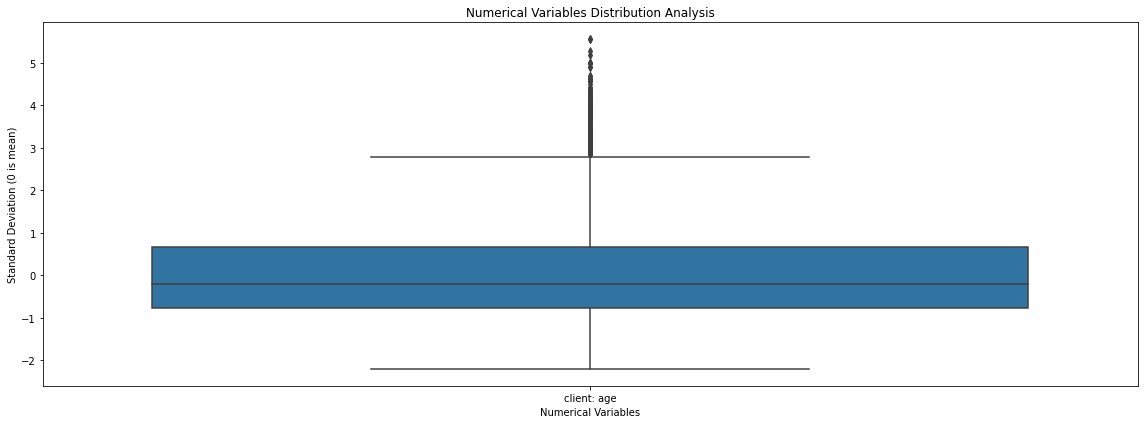

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

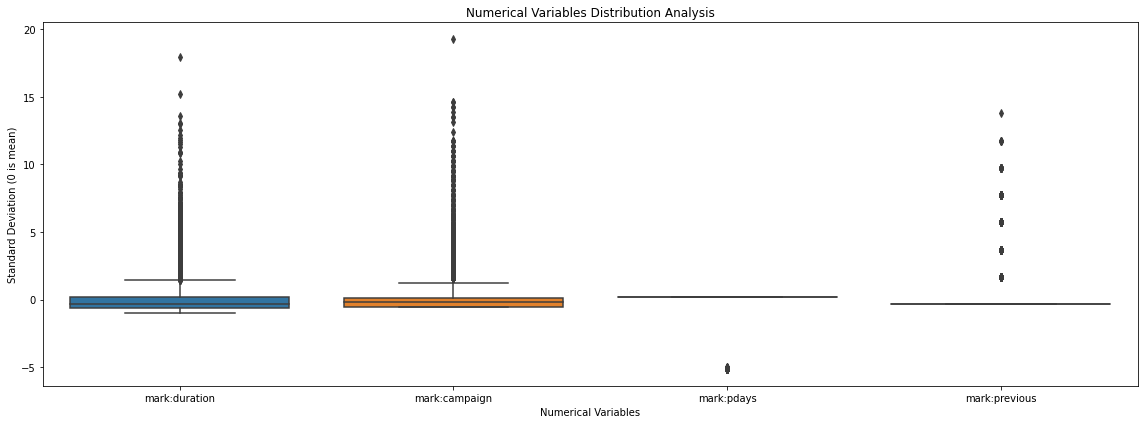

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

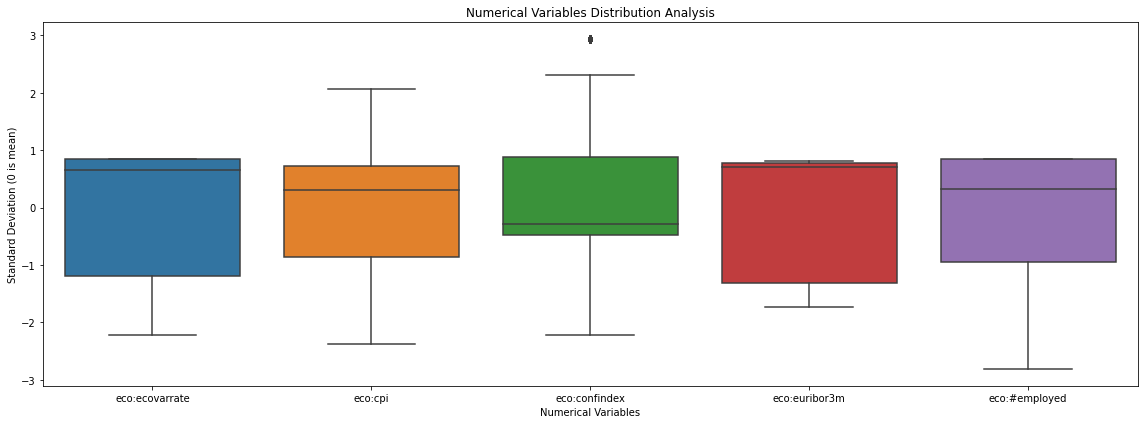

In [22]:
print('Box Plots showing the:')
print('1) Numerical Variables Distribution Analysis')
print('2) Outliers outside the whiskers of the box plot')
#print('3) Data points as Swarm dots')

df = BankMarketing_X.select_dtypes(include=['number'])
x_transform = pd.DataFrame(StandardScaler().fit_transform(df),columns=(df.columns.tolist()))

text = ['client','mark','eco']

for string in text:
    col_list = [x for x in df.columns.tolist() if re.search(string, x)]
    df_small = x_transform.filter(col_list)
    plt.figure(figsize=(16,6))
    sns.boxplot(data=df_small)
    #sns.swarmplot(data=df_small,size=2)
    plt.title("Numerical Variables Distribution Analysis") ; plt.xlabel('Numerical Variables'); plt.ylabel('Standard Deviation (0 is mean)')
    plt.tight_layout() ; plt.show()

#### Categorical Values Analysis

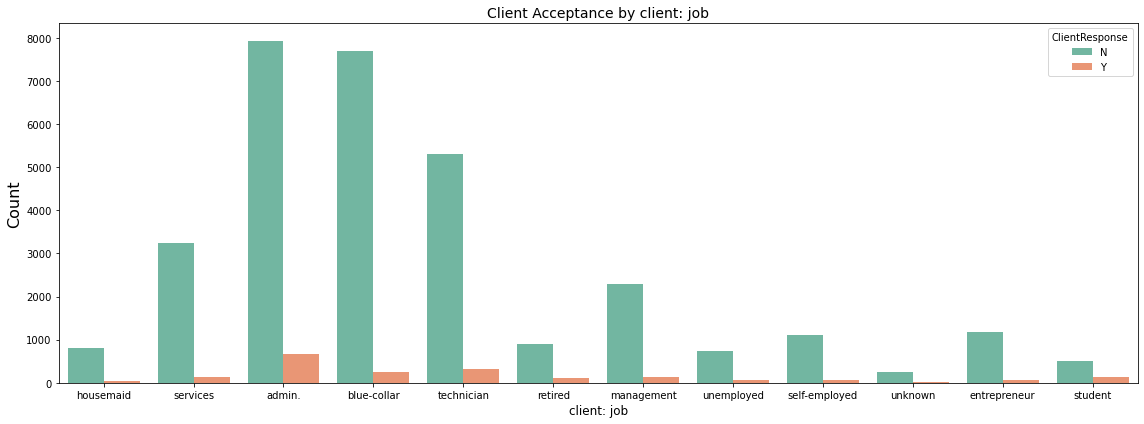

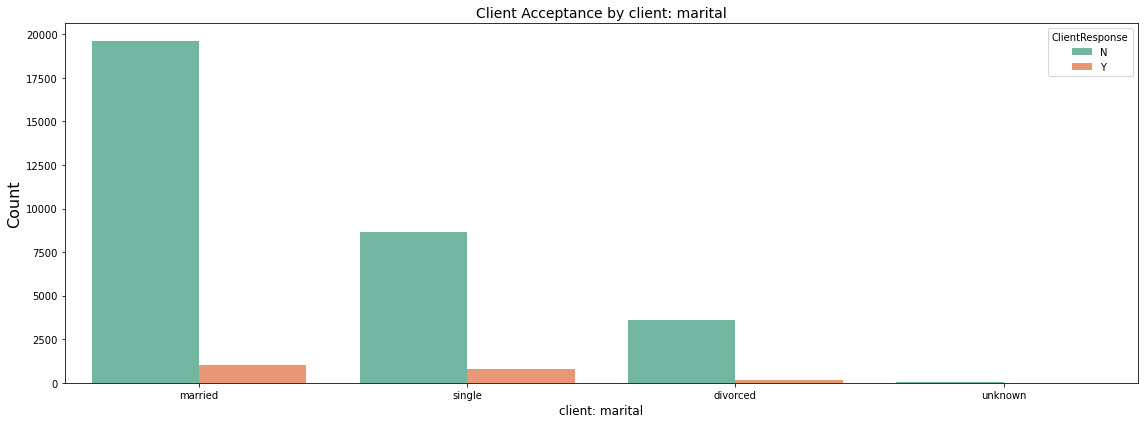

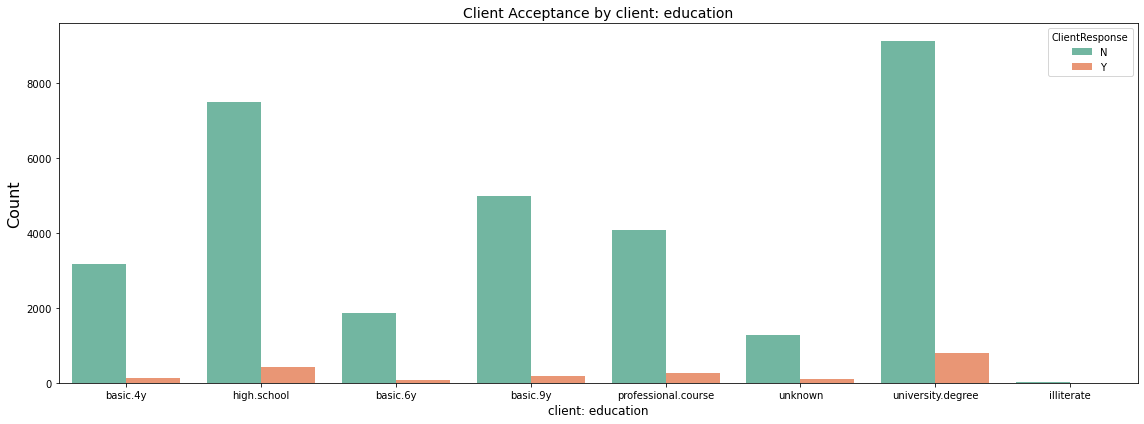

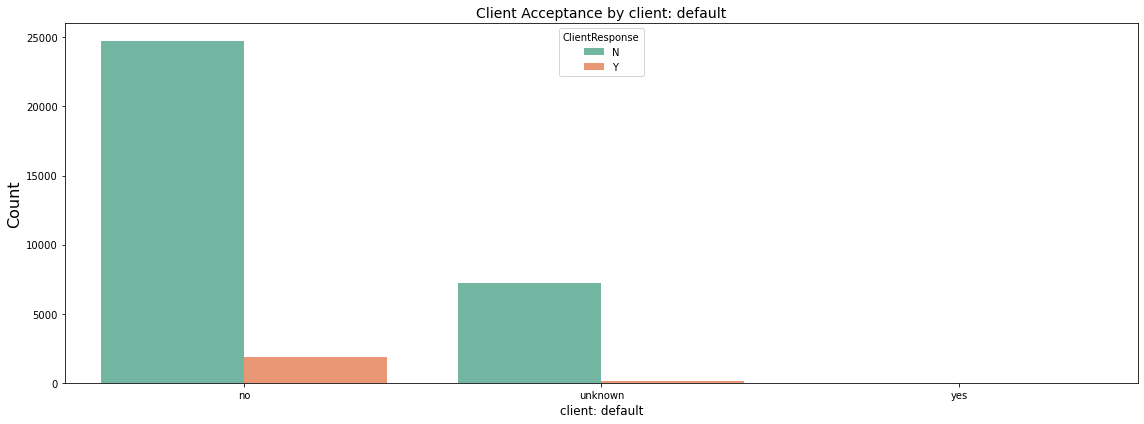

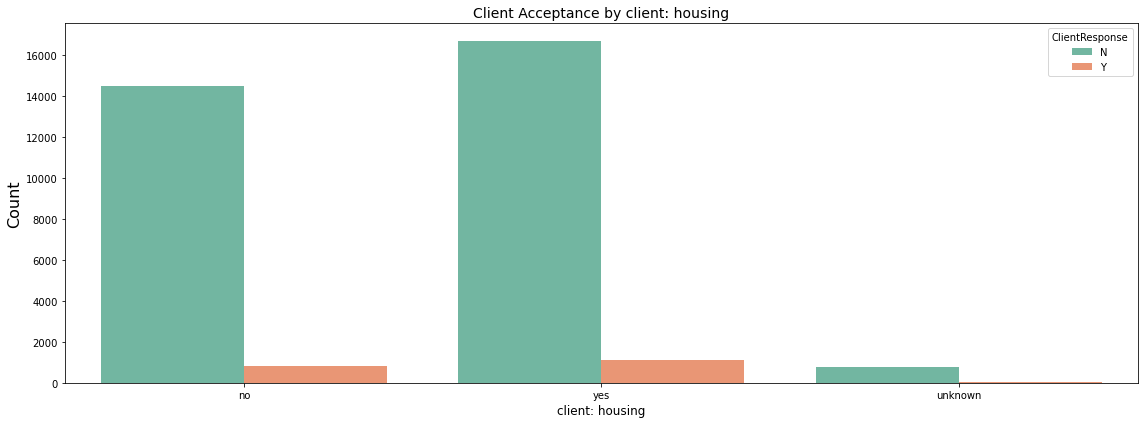

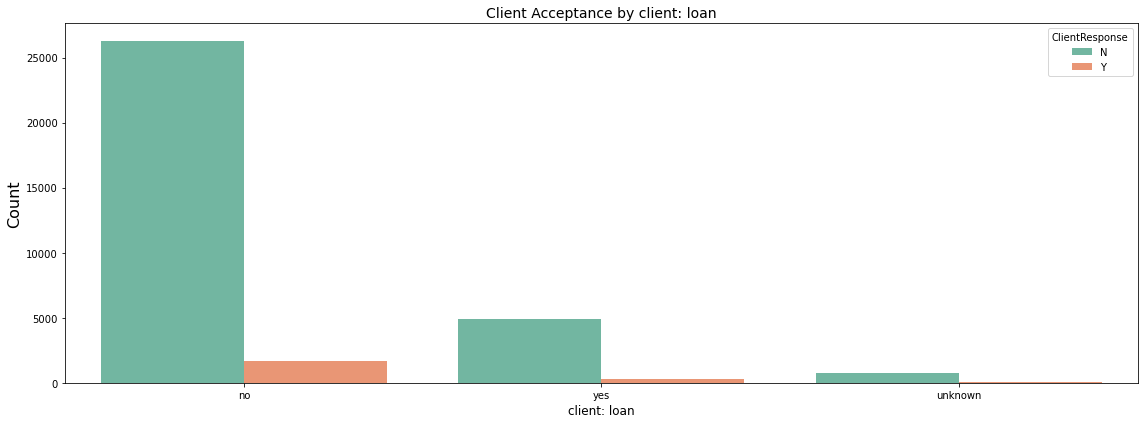

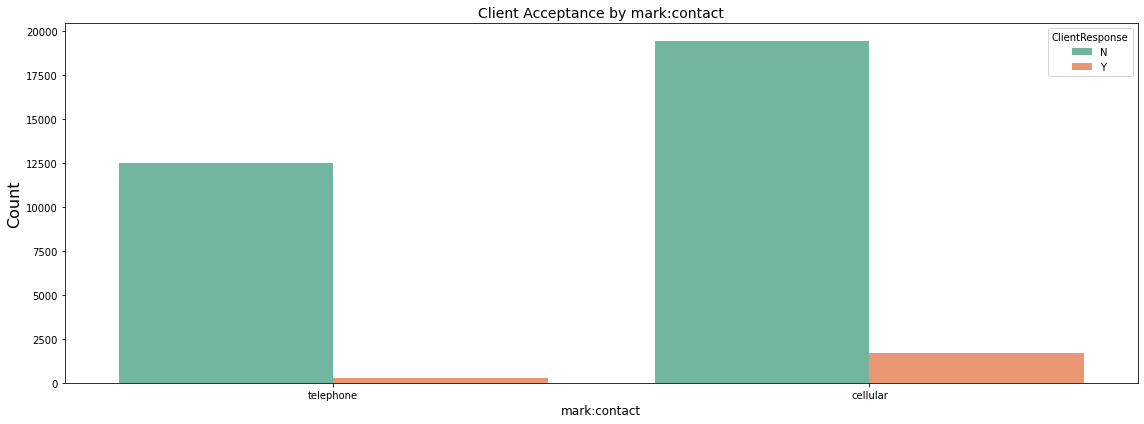

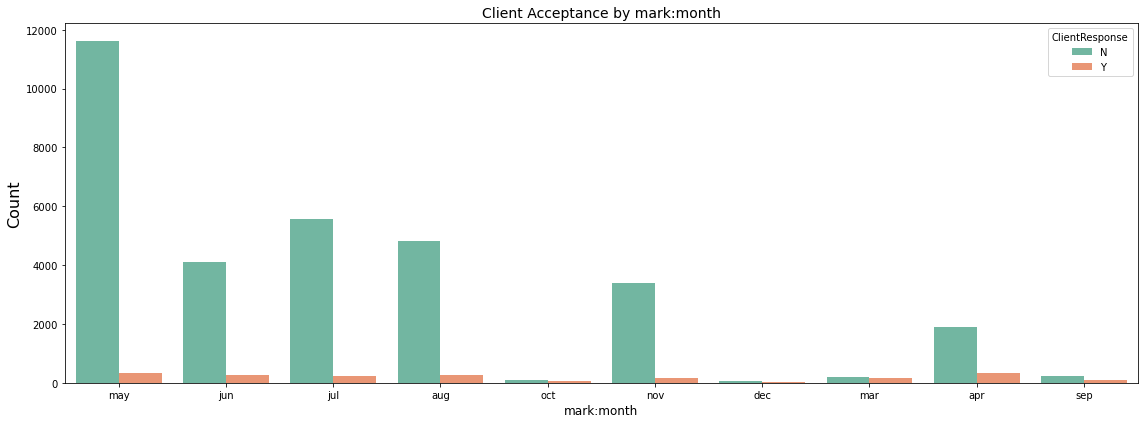

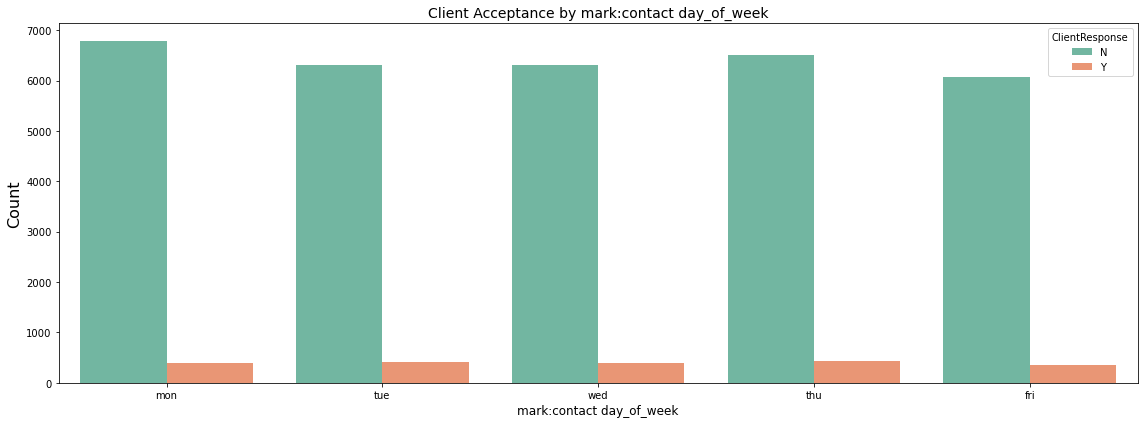

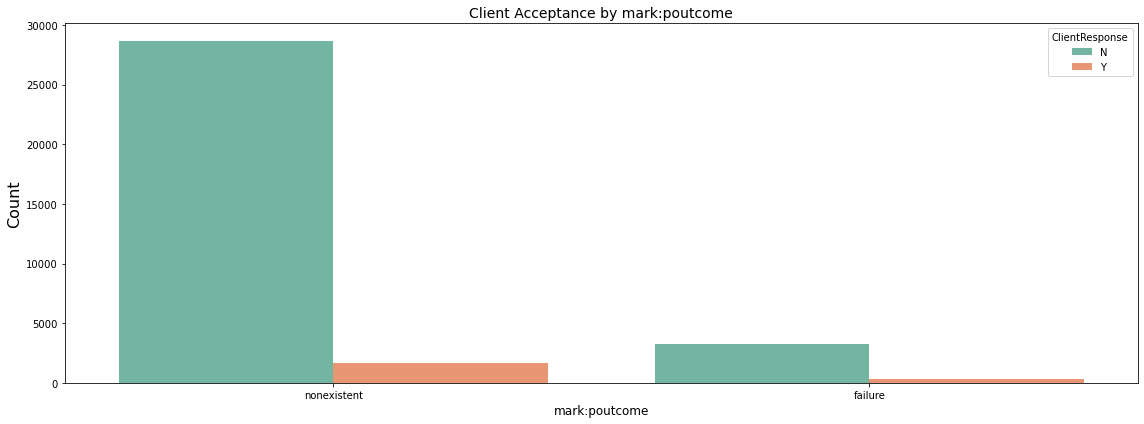

In [23]:
cat_feature = BankMarketing_X.select_dtypes(include=['object', 'category']).columns.values

df = BankMarketing

for col in cat_feature:
    plt.figure(figsize=(16, 6))
    sns.countplot(data=df, x=col,hue='ClientResponse',palette='Set2')
    plt.title(f'Client Acceptance by {col}',fontsize=14); plt.xlabel(col,fontsize=12); plt.ylabel('Count',fontsize=16)
    plt.tight_layout() ; plt.show()

### D2) Inferential Statistics

- relations among features
 - relations between features and target variable (y)
 - hypothesis testing
 - Statistical analysis for finding important features - Chi, ANOVA, F1, t-test, other

#### Correlation Matrix for Numerical Variables

<AxesSubplot:>

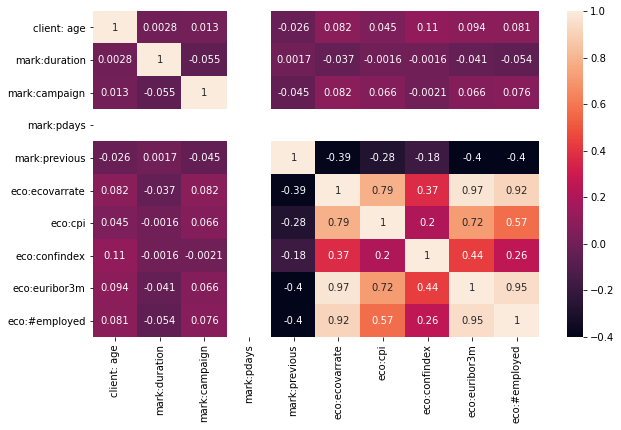

In [24]:
plt.figure(figsize=(10, 6))
sns.heatmap(BankMarketing.corr(), annot=True)


<Figure size 864x864 with 0 Axes>

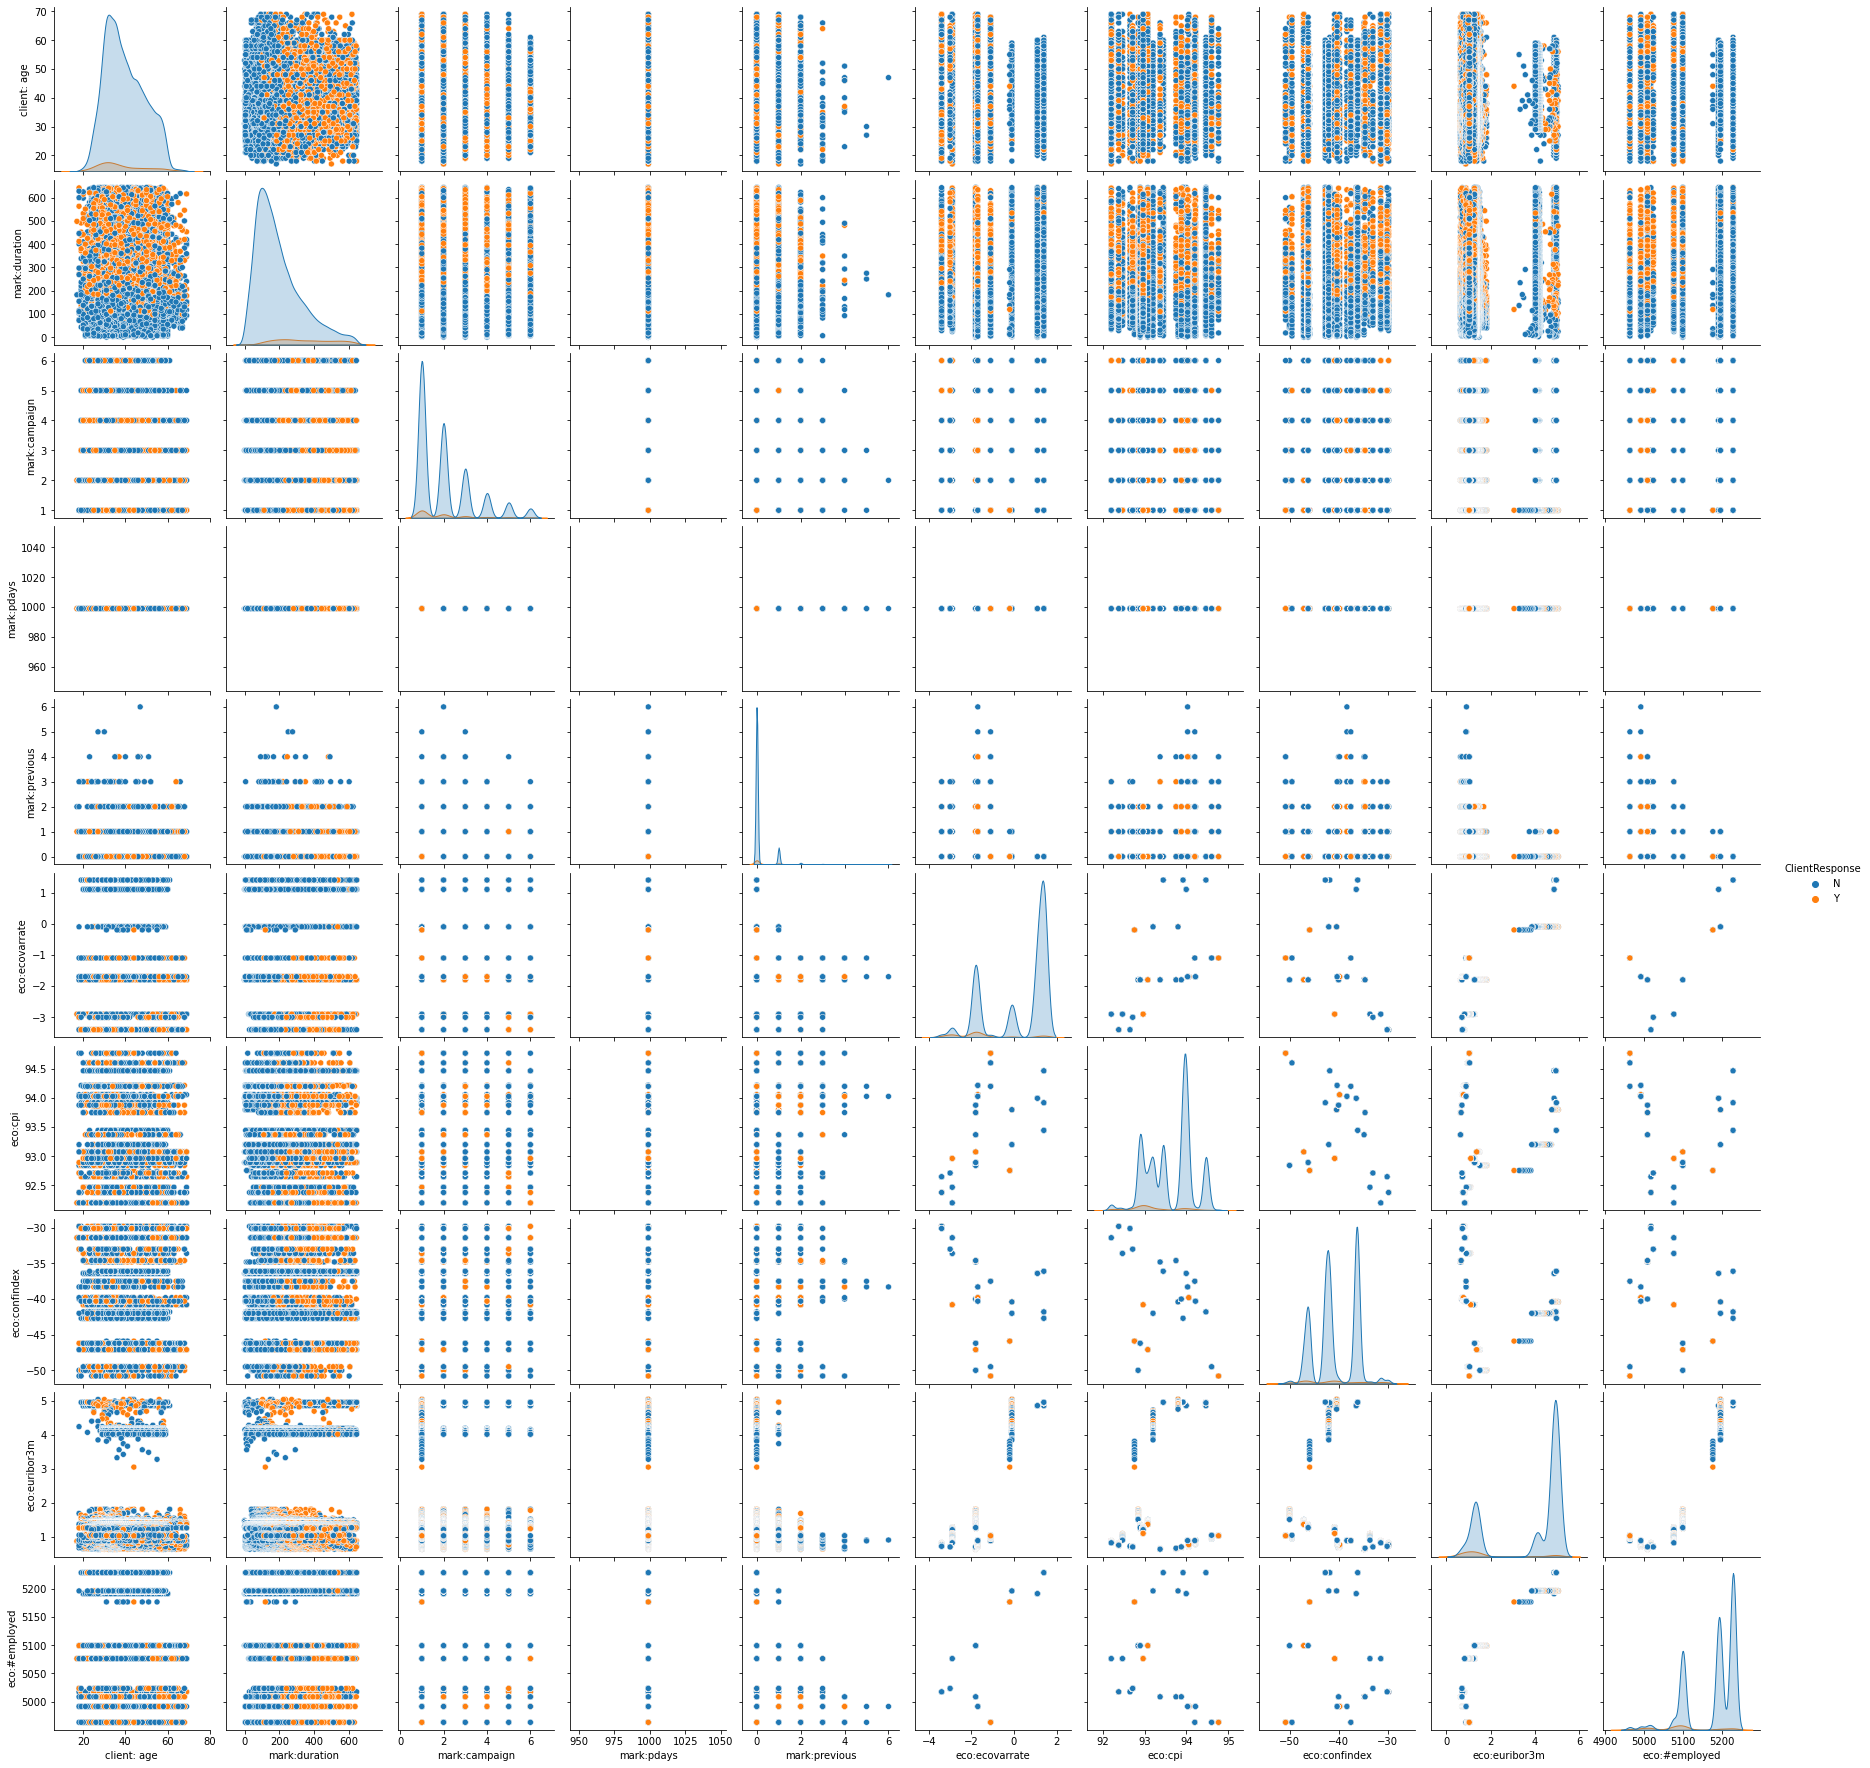

In [25]:
# Bivariate Numerical to Numerical Analysis using Pair Plots

# Demonstrates Class Separatability for combinations of Features

plt.figure(figsize=(12,12))
sns.pairplot(BankMarketing, hue='ClientResponse')
plt.show()

#### Relation among Numerical Features

In [26]:
# My custom function to get Highly Correlated features

get_high_correlated_features(BankMarketing)

There are 5 feature combinations that are HIGHLY correlated by Pearson Correlation Coefficient
There are 5 feature combinations that are HIGHLY positively correlated by Pearson Correlation Coefficient
There are 0 feature combinations that are HIGHLY negatively correlated by Pearson Correlation Coefficient


,Feature 1,Feature 2,PearsonCorrCoef
26,eco:ecovarrate,eco:cpi,0.789916
28,eco:ecovarrate,eco:euribor3m,0.974941
29,eco:ecovarrate,eco:#employed,0.915792
31,eco:cpi,eco:euribor3m,0.720250
35,eco:euribor3m,eco:#employed,0.947261


We see None of the numerical features show STRONG correlation with Y

Notice, the economic environmental data is highly correlated with each other.

This is useful information. We will feature engineer to merger these 5 features into 2-3 features

#### Quick PCA visualization to understand how well the Classes are separated

<IPython.core.display.Javascript object>

Preserved variance is:  67.12 %
PCA features:           [0.47149182 0.19967828]


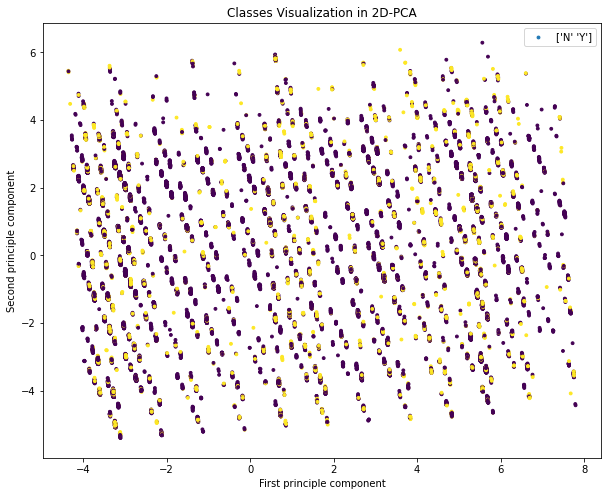

In [27]:
visualize_classes_in_pca(BankMarketing_X,BankMarketing_y)

I tried to see the class separation in 2D PCA but in this case I am not able to since the Preserved variance is only 67.12 %

There is poor class separation with just these 2 features.

In [ ]:
#### Visualizing Percent of Client Response Acceptance and Rejection

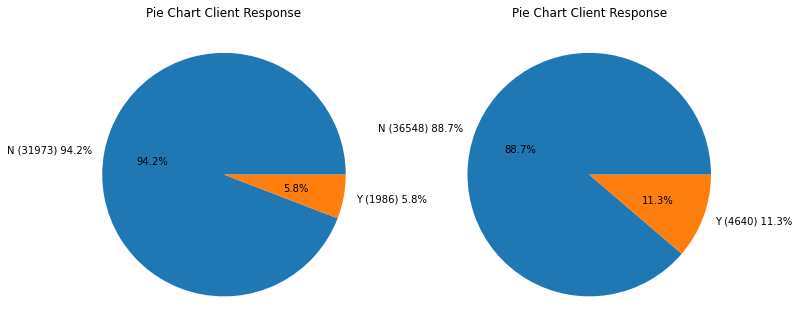

In [28]:
plt.figure(figsize=(12,12))

plt.subplot(1, 2, 1)
counts = BankMarketing['ClientResponse'].value_counts()
# Create labels with counts and percentages
labels = [f'{label} ({count}) {count/sum(counts)*100:.1f}%' for label, count in zip(counts.index, counts)]
# Create a pie chart
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Pie Chart Client Response')

plt.subplot(1, 2, 2)
counts = data['ClientResponse'].value_counts()
# Create labels with counts and percentages
labels = [f'{label} ({count}) {count/sum(counts)*100:.1f}%' for label, count in zip(counts.index, counts)]
# Create a pie chart
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Pie Chart Client Response')


plt.show()

In [ ]:
Notice how the number of 'N' got substantively reduced by the cleaning process.

This is because a lot of 'N' got removed by the outlier removal.

This is an issue.

We will evaluate the models with: retaining outliers and by removing outliers and see the difference.
    
This is a TRADE-OFF decision - Outlier Removal Benefit Vs Data Loss of already sparse class

## Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.
What is the baseline performance that our classifier should aim to beat?

## Section E: Metrics & Baseline

This section contains:

 1. considerations of Metrics for Test/Evaluation Design
 2. Baseline score against which we will compare

### E1) Metrics

for this classification problem 5 metrics will be considered:

 1. Recall
 2. Precision
 3. F1 score
 4. Training Accuracy
 5. Test Accuracy

### E2) Baseline

Baseline helps to get an accurate benchmark against which the Evaluation results can be compared.

There are multiple ways to get to a baseline.

Typical methods for Baseline estimation include: Dummy Classifier & Random Classifier for Classification Problems.

### Setting up Higher Benchmarks to beat

But I am setting up a HIGHER BENCHMARK.

I am going to take the AVERAGE of Multiple Out of Box models as the Baseline.

I will then compare this against the Scores after Feature Engineering and Model Engineering (fine-tuning)

**Models used for getting to Baseline Score**

 1. LogisticRegression
 2. KNeighborsClassifier
 3. GradientBoostingClassifier
 4. Support Vector Machine Classifier
 5. Decision Tree
 6. Random Forest Classifier
 7. AdaBoostClassifier
 8. Multi Layer Perceptron
 9. Linear Discriminant Analysis

In [29]:
# Running Baseline Evaluation

BankMarketing_X_scaled = preprocessX(BankMarketing_X)
BankMarketing_y_scaled = LabelEncoder().fit_transform(BankMarketing_y)

tik = time.time() 
evaluation_baseline = evalC(BankMarketing_X_scaled, BankMarketing_y_scaled)
tok = time.time()

print('Time to run the baseline evaluation with multiple models:' , '%.2f' % (tok-tik) , 'seconds')

evaluation_baseline

Time to run the baseline evaluation with multiple models: 103.20 seconds


,LOG,KNN,GBC,SVC,DEC,RAF,ABC,ETC,MLP,LDA
precision,0.7972,0.7241,0.8069,0.7638,0.7179,0.7910,0.7164,0.7793,0.7892,0.7714
recall,0.6834,0.5976,0.7473,0.6003,0.7202,0.7289,0.7226,0.6863,0.7386,0.7185
f1,0.7221,0.6264,0.7726,0.6333,0.7190,0.7548,0.7194,0.7200,0.7605,0.7409
acc_train,0.9106,0.9120,0.9215,0.8974,1.0000,1.0000,1.0000,1.0000,0.9249,0.9091
acc_test,0.9107,0.8924,0.9188,0.8982,0.8884,0.9133,0.8876,0.9074,0.9136,0.9075


In [31]:
# Arriving at Average Model Baseline

evaluation_baseline_withBC =  evaluation_baseline.apply(pd.to_numeric, errors='coerce')
evaluation_baseline_withBC['Average Baseline Scores'] = round(evaluation_baseline_withBC.mean(axis=1),4)

print('Here is our Higher Standards Baseline Score')
      
evaluation_baseline_withBC

Here is our Higher Standards Baseline Score


,LOG,KNN,GBC,SVC,DEC,RAF,ABC,ETC,MLP,LDA,Average Baseline Scores
precision,0.7972,0.7241,0.8069,0.7638,0.7179,0.7910,0.7164,0.7793,0.7892,0.7714,0.7657
recall,0.6834,0.5976,0.7473,0.6003,0.7202,0.7289,0.7226,0.6863,0.7386,0.7185,0.6944
f1,0.7221,0.6264,0.7726,0.6333,0.7190,0.7548,0.7194,0.7200,0.7605,0.7409,0.7169
acc_train,0.9106,0.9120,0.9215,0.8974,1.0000,1.0000,1.0000,1.0000,0.9249,0.9091,0.9476
acc_test,0.9107,0.8924,0.9188,0.8982,0.8884,0.9133,0.8876,0.9074,0.9136,0.9075,0.9038


## Section G: Feature Engineering

This section contains new features engineering, feature selection, feature scaling, feature Train/Test split

## Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started. Before we can do this, we must work to encode the data. Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

This will be done in 4 parts:

 1. creating new features
 2. analyzing selection possibilities and if feasible making a features subset
 3. scaling features
 4. Train/Test split

### G1) New Features Engineering

#### ECONOMIC FEATURE ENGINEERING

Notice how the Economic Environmental Features are all correlated.

This is intuitive because in a prevailing environment, different metrics to assess the economic situation are likely to be correlated and similar.

We will merge these 5 features into 2 featuring by applying PCA technique

get_high_correlated_features(BankMarketing)

In [33]:

economicfeatures =  ['eco:ecovarrate','eco:cpi','eco:confindex','eco:euribor3m','eco:#employed']

# Standardize the features
x = BankMarketing[economicfeatures].values
x = StandardScaler().fit_transform(x)

# Apply PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

economicfeaturesPCA = pd.DataFrame(data=principalComponents, columns=['economicdata:PCA1', 'economicdata:PCA2'])

BankMarketing = pd.concat([BankMarketing, economicfeaturesPCA], axis=1)

BankMarketing = BankMarketing.drop(economicfeatures, axis=1, errors='ignore')

BankMarketing.head()

<IPython.core.display.Javascript object>

,ClientResponse,client: age,client: job,client: marital,client: education,client: default,client: housing,client: loan,mark:contact,mark:month,mark:contact day_of_week,mark:duration,mark:campaign,mark:pdays,mark:previous,mark:poutcome,economicdata:PCA1,economicdata:PCA2
0,N,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,-1.306312,0.696707
1,N,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,-1.306312,0.696707
2,N,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,-1.306312,0.696707
3,N,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,-1.306312,0.696707
4,N,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,-1.306312,0.696707


In [34]:
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio per component:", explained_variance)
print("Total preserved variance:", '%.2f' % (explained_variance.sum()*100),'%')
print("Number of PCA components:", pca.n_components_)

Explained variance ratio per component: [0.69421113 0.19655831]
Total preserved variance: 89.08 %
Number of PCA components: 2


### G2) Feature Selection

We can employ External Filtering Methods (Statistical) or Internal Filtering Methods (wrapped around a model)

In [35]:
# Lib & custom function
from scipy.stats import chi2_contingency
def chi_square_test(feature, target):
    contingency_table = pd.crosstab(feature,target)
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    return chi2, p

# Declare variables

chi_x_catfeatures = BankMarketing_X.select_dtypes(include=['object', 'category']).columns.values
chi_y = BankMarketing_y.columns.tolist()

#### put dataset name in 1 line of for code below 

In [36]:
results = []

# Get chi2 values
for feature in chi_x_catfeatures:
    chi2, p = chi_square_test(BankMarketing[feature], BankMarketing['ClientResponse'])
    results.append({'features': feature, 'Chi2': chi2, 'p-value': p})

featimp_chi = pd.DataFrame(results)

featimp_chi['featurerank_chi'] = featimp_chi['Chi2'].rank(ascending=False)

featimp_chi = featimp_chi.sort_values(by='featurerank_chi')

print('These are the Features of the dataset ranked by Chi2 Statistical Method')

featimp_chi

These are the Features of the dataset ranked by Chi2 Statistical Method


,features,Chi2,p-value,featurerank_chi
9,mark:poutcome,4230.523798,0.000000e+00,1.0
7,mark:month,3101.149351,0.000000e+00,2.0
0,client: job,961.242440,4.189763e-199,3.0
6,mark:contact,862.318364,1.525986e-189,4.0
3,client: default,406.577515,5.161958e-89,5.0
2,client: education,193.105905,3.305189e-38,6.0
1,client: marital,122.655152,2.068015e-26,7.0
8,mark:contact day_of_week,26.144939,2.958482e-05,8.0
4,client: housing,5.684496,5.829448e-02,9.0
5,client: loan,1.094028,5.786753e-01,10.0


Interesting Marketing Month has got the highest score.

The client personal/financial data have a high Chi Square value is intuitive.

For Now, I am not removing any features on the basis of this score.

### G3) Feature Scaling

 1. Using my custom defined Scaling Function I am applying MinMax Scaling to my Numerical Features
 2. Using my custom defined Scaling Function I am applying MinMax Scaling to my Numerical Features
 3. I use Label Encoder for Scaling Target Variable

In [37]:
# X/y split
y_column = ['ClientResponse']
BankMarketing_X  = BankMarketing.drop(y_column, axis=1, errors='ignore')
BankMarketing_y  = BankMarketing[y_column].copy()

# scaling
BankMarketing_X_scaled = preprocessX(BankMarketing_X)
BankMarketing_y_scaled = LabelEncoder().fit_transform(BankMarketing_y)

## Problem 6: Train/Test Split
With your data prepared, split it into a train and test set.

### G4) Feature Train/Test Split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(BankMarketing_X_scaled, BankMarketing_y_scaled, test_size = 0.2)

## Section H: Model Engineering

Here I run the models on the train, do a round of evaluation, and perform Hyperparameter tuning

### H1) Models Introduction

The Models specified for this practical Assignment are:

 1. Logistic Regression
 2. K Nearest Neighbors
 3. Decision Trees
 4. Support Vector Classifier

In [39]:
# Here is the Out of Box Model Performance Baseline Scores from Section E

evaluation_baseline_withBC

,LOG,KNN,GBC,SVC,DEC,RAF,ABC,ETC,MLP,LDA,Average Baseline Scores
precision,0.7972,0.7241,0.8069,0.7638,0.7179,0.7910,0.7164,0.7793,0.7892,0.7714,0.7657
recall,0.6834,0.5976,0.7473,0.6003,0.7202,0.7289,0.7226,0.6863,0.7386,0.7185,0.6944
f1,0.7221,0.6264,0.7726,0.6333,0.7190,0.7548,0.7194,0.7200,0.7605,0.7409,0.7169
acc_train,0.9106,0.9120,0.9215,0.8974,1.0000,1.0000,1.0000,1.0000,0.9249,0.9091,0.9476
acc_test,0.9107,0.8924,0.9188,0.8982,0.8884,0.9133,0.8876,0.9074,0.9136,0.9075,0.9038


### H2) Logistic Regression

Out of Box model performance: Best Recall score, performs well by F1 metric, Test accuracy is 2nd best among the 4 models

Hyperparameters for consideration:

 1. C: Inverse of regularization strength; must be a positive float. Options: Any positive float.

 2. Penalty: Specifies the norm used in the penalization. Options: 'l1', 'l2', 'elasticnet', 'none'

 3. Solver: Algorithm to use in the optimization problem. Options: 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'

### H3) K Nearest Neighbor Regression

Out of Box model performance: recall, precision and F1 is below baseline , average performance by Test accuracy 

Hyperparameters for consideration:

 1. n_neighbors: Number of neighbors to use. Options: Any positive integer.

 2. weights: Weight function used in prediction. Options: 'uniform', 'distance', callable'

 3. p: Power parameter for the Minkowski metric. Options: 1 (Manhattan distance), 2 (Euclidean distance), arbitrary float (Minkowski distance)

### H4) Decision Tree

Out of Box model performance: performs very low on Recall, Training accuracy is below average, other test results are average

Hyperparameters for consideration:

 1. C: Inverse of regularization strength; must be a positive float. Options: Any positive float.

 2. Penalty: Specifies the norm used in the penalization. Options: 'l1', 'l2', 'elasticnet', 'none'

 3. Solver: Algorithm to use in the optimization problem. Options: 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'

### H5) Support Vector Classifier

Out of Box model performance: Best Recall score, performs well by F1 metric, Test accuracy is 2nd best among the 4 models

Hyperparameters for consideration:

 1. kernel: Specifies the kernel type to be used in the algorithm. Options: 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'

 2. C: Regularization parameter; must be a positive float. Options: Any positive float.

 3. gamma: Kernel coefficient for 'rbf', 'poly', and 'sigmoid'. Options: 'scale', 'auto', or any positive float

### H6) Grid Search for getting Best Model Hyperparameters

In [ ]:
# Lets run the Grid Search for all 4 classifiers

In [40]:
param_grid = {
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1], 'penalty' : ['l1','l2'], 'solver': ['lbfgs', 'liblinear']},
    'KNN': {'n_neighbors': [5,10,15,20],'weights' : ['uniform', 'distance'],'p':[1,2]},
    'Decision Tree' : {'max_depth': [None, 4, 8, 16],'min_samples_split': [2, 4, 8], 
    'min_samples_leaf': [1, 2, 4], 'criterion': ['gini', 'entropy']},
    'SVC': {'kernel': ['rbf'], 'C': [0.1], 'gamma': [1]}
}

models = {'Logistic Regression': LogisticRegression(),'KNN': KNeighborsClassifier(),
          'Decision Tree':DecisionTreeClassifier(), 'SVC': SVC()}

best_models = {}
best_params = {}
timetaken_gridsearch = []

In [41]:
tik1 = time.time()

for name, model in models.items():
    
    tik = time.time()
    
    grid = GridSearchCV(model, param_grid[name], cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)
    
    best_models[name] = grid.best_estimator_
    best_params[name] = grid.best_params_
    
    tok = time.time()
    print('Time to run the GridSearch for' , name , 'is:' , '%.2f' % (tok-tik) , 'seconds')
    timetaken_gridsearch.append('%.1f' % (tok-tik))

tok1 = time.time()
print('Time to run the GridSearch evaluation for multiple models:' , '%.2f' % (tok1-tik1) , 'seconds')
 

Time to run the GridSearch for Logistic Regression is: 10.72 seconds
Time to run the GridSearch for KNN is: 63.96 seconds
Time to run the GridSearch for Decision Tree is: 32.44 seconds
Time to run the GridSearch for SVC is: 786.36 seconds
Time to run the GridSearch evaluation for multiple models: 893.48 seconds


Now we have the best Hyperparameters for All models. Lets run the final evaluation for all these 4 classifier models.


## Section I: Evaluation

This section contains comparison of classifier models and a sub-section for Important features Identification

### I1) Comparison of Classifier Models

In [58]:
# Running Evaluation metrics for best parameters of all 4 models

names  = ['Logistic Regression', 'KNN', 'Decision Tree', 'SVC']

precision = []
recall = []
f1 = []
acc_train = []
acc_test  = []

In [59]:
for name, model in best_models.items():
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    precision_calc,recall_calc,f1score_calc,support_calc=score(y_test,y_pred,average='macro')
    
    precision.append("%.4f" % precision_calc)
    recall.append("%.4f" % recall_calc)
    f1.append("%.4f" % f1score_calc)
 
    acc_train.append("%.4f" % model.score(X_train, y_train))
    acc_test.append("%.4f" % model.score(X_test, y_test))
         
    Df = pd.DataFrame({'precision':precision,'recall':recall,'f1':f1,'acc_train':acc_train,'acc_test':acc_test})
    Df = Df.T

Df.columns = names
evaluation_final = Df.apply(pd.to_numeric, errors='coerce')

evaluation_final

,Logistic Regression,KNN,Decision Tree,SVC
precision,0.7915,0.7589,0.7737,0.4441
recall,0.6810,0.5521,0.7530,0.5000
f1,0.7187,0.5669,0.7628,0.4704
acc_train,0.9066,0.8990,0.9249,0.8871
acc_test,0.9088,0.8931,0.9093,0.8882


In [54]:
# Baseline Scores

evalbase=evaluation_baseline_withBC[['LOG','KNN','DEC','SVC','Average Baseline Scores']]
evalbase

,LOG,KNN,DEC,SVC,Average Baseline Scores
precision,0.7972,0.7241,0.7179,0.7638,0.7657
recall,0.6834,0.5976,0.7202,0.6003,0.6944
f1,0.7221,0.6264,0.7190,0.6333,0.7169
acc_train,0.9106,0.9120,1.0000,0.8974,0.9476
acc_test,0.9107,0.8924,0.8884,0.8982,0.9038


In [45]:
# Logistic Regression

# precision & F1 drops with new hyperparameters
# So I am retaining default values for hyperparameters and running the tests again

# Logistic Regression Retest

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
score(y_test,y_pred,average='macro')

0.9061911987860395
0.9083515416363195


(0.7947298190897217, 0.6698445323215447, 0.7096373324910218, None)

In [61]:
# Appending New Log Reg scores and Baseline Scores into evaluation df

evaluation_final_adjusted = evaluation_final

evaluation_final_adjusted['Logistic Regression'] = [0.7601,0.6800,0.6824,0.9478,0.9439]

evaluation_final_adjusted['Average Baseline Scores'] = evalbase['Average Baseline Scores']

evaluation_final_adjusted

,Logistic Regression,KNN,Decision Tree,SVC,Average Baseline Scores
precision,0.7601,0.7589,0.7737,0.4441,0.7657
recall,0.6800,0.5521,0.7530,0.5000,0.6944
f1,0.6824,0.5669,0.7628,0.4704,0.7169
acc_train,0.9478,0.8990,0.9249,0.8871,0.9476
acc_test,0.9439,0.8931,0.9093,0.8882,0.9038


In [ ]:
# K Nearest Classifier

# Hyperparameters improve precision, recall and F1 scores

In [ ]:
## Decision Tree

# Wowwwwwwwwwwwww! Decision Tree performs exceedingly well after feature engineering & model engineering

# This is the best classifier among the 4 classifier for this problem

In [ ]:
# SVC

# Hyperparameters improve decrease precision, but other scores are marginally better

In [64]:
# Evaluation Grid

#Adding Time taken
# Note the time taken for SVC is adjusted with the previous run where it took 990 seconds for running 2 combinations of SVC

evaluation_final_adjusted['runtime(s)'] = timetaken_gridsearch
evaluation_final_adjusted['runtime(s)'] = evaluation_final_adjusted['runtime(s)'].astype('float64')

EVALGRID = evaluation_final_adjusted

EVALGRID

,precision,recall,f1,acc_train,acc_test,runtime(s)
Logistic Regression,0.7601,0.6800,0.6824,0.9478,0.9439,103.2
KNN,0.7589,0.5521,0.5669,0.8990,0.8931,10.7
Decision Tree,0.7737,0.7530,0.7628,0.9249,0.9093,64.0
SVC,0.4441,0.5000,0.4704,0.8871,0.8882,32.4
Average Baseline Scores,0.7657,0.6944,0.7169,0.9476,0.9038,1486.4


### I2) Important features Identification

#### Feature Importance by Logistics Regression Coefficients

In [69]:

model_logreg = LogisticRegression()
model_logreg.fit(X_train, y_train)

featimp_log = pd.DataFrame({'features': BankMarketing_X.columns.tolist(), 'coefficients':model_logreg.coef_[0]})

featimp_log['featurerank_log'] = featimp_log['coefficients'].rank(ascending=False)
featimp_log = featimp_log.sort_values(by='featurerank_log')

print('These are the Features of the dataset ranked by Coefficient values of Logistic Regression')
featimp_log

These are the Features of the dataset ranked by Coefficient values of Logistic Regression


,features,coefficients,featurerank_log
1,client: job,19.133518,1.0
5,client: housing,2.610277,2.0
6,client: loan,1.026726,3.0
0,client: age,1.000653,4.0
16,economicdata:PCA2,0.311812,5.0
4,client: default,0.215778,6.0
8,mark:month,0.174443,7.0
9,mark:contact day_of_week,0.062585,8.0
15,economicdata:PCA1,0.052492,9.0
7,mark:contact,0.015786,10.0


#### Feature Importance by Decision Tree Feature Importance

In [70]:
model_dectree = DecisionTreeClassifier()
model_dectree.fit(X_train, y_train)

featimp_dec = pd.DataFrame({'features': BankMarketing_X.columns.tolist(), 'decfeatimp':model_dectree.feature_importances_})

featimp_dec['featurerank_dec'] = featimp_dec['decfeatimp'].rank(ascending=False)
featimp_dec = featimp_dec.sort_values(by='featurerank_dec')


print('These are the Features of the dataset ranked by Coefficient values of Decision Tree')
featimp_dec

These are the Features of the dataset ranked by Coefficient values of Decision Tree


,features,decfeatimp,featurerank_dec
1,client: job,0.340565,1.0
5,client: housing,0.139944,2.0
3,client: education,0.099423,3.0
0,client: age,0.094935,4.0
6,client: loan,0.089026,5.0
9,mark:contact day_of_week,0.042947,6.0
7,mark:contact,0.042846,7.0
2,client: marital,0.029910,8.0
15,economicdata:PCA1,0.029478,9.0
8,mark:month,0.021313,10.0


In [71]:
featimp = pd.merge(featimp_log, featimp_dec, on='features', how='inner')

featimp = pd.merge(featimp, featimp_chi, on='features', how='outer')

featimp['rankavg'] = featimp[['featurerank_log', 'featurerank_dec', 'featurerank_chi']].mean(axis=1)

# Incorrect ranking with reverse order. this value is only for feature importance representation in bar chart
featimp['weightage_for_representation'] = featimp['rankavg'].rank(ascending=False)

featimp['weightedrank'] = featimp['rankavg'].rank()

featimp = featimp.sort_values(by='weightedrank')

featimp_display = featimp[['features','featurerank_log','featurerank_dec', 'featurerank_chi','weightedrank']]
featimp_display

,features,featurerank_log,featurerank_dec,featurerank_chi,weightedrank
0,client: job,1.0,1.0,3.0,1.0
3,client: age,4.0,4.0,NaN,2.0
1,client: housing,2.0,2.0,9.0,3.0
2,client: loan,3.0,5.0,10.0,4.0
6,mark:month,7.0,10.0,2.0,5.0
9,mark:contact,10.0,7.0,4.0,6.0
7,mark:contact day_of_week,8.0,6.0,8.0,7.0
12,mark:poutcome,13.0,11.0,1.0,8.5
5,client: default,6.0,14.0,5.0,8.5
16,client: education,17.0,3.0,6.0,10.0


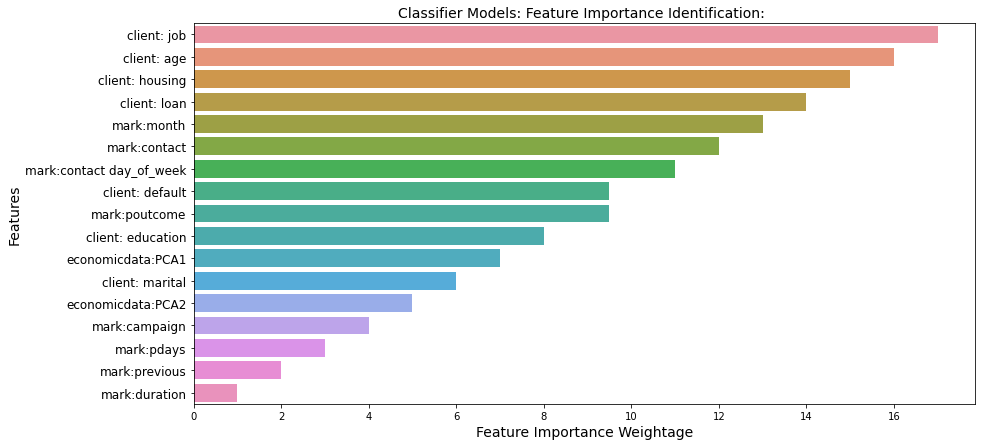

In [72]:
plt.figure(figsize=(14, 7))

sns.barplot(data=featimp.sort_values(by='weightage_for_representation', ascending=False), x='weightage_for_representation', y='features')

plt.title('Classifier Models: Feature Importance Identification: ', fontsize=14)
plt.xlabel('Feature Importance Weightage', fontsize=14);plt.ylabel('Features', fontsize=14); 
plt.xticks(fontsize=10); plt.yticks(fontsize=12);plt.show()

## Section J: Report

This is section is the final report with results, discussion, conclusion & summary

 1. Data columns cyratwere curated - SIR curation - Sorting, Irrelevant column removal, Renaming
 2. Data row issues were handled - DON curation - 12 duplicates removed, some outliers removed, no nulls
 3. Data data special issues were handled

 4. Metrics for this classification problem:

    1. Recall
    2. Precision
    3. F1 score
    4. Training Accuracy
    5. Test Accuracy

In [74]:
#5 High Benchmark Baselining

# 10 out-of-box scikit learn models were run and their average scores is the baselining for the 4 models

evaluation_baseline

,LOG,KNN,GBC,SVC,DEC,RAF,ABC,ETC,MLP,LDA
precision,0.7676,0.6896,0.7844,0.7510,0.7138,0.7836,0.7142,0.7650,0.7680,0.7550
recall,0.6724,0.5848,0.7500,0.5921,0.7254,0.7479,0.7298,0.6868,0.7160,0.7163
f1,0.7059,0.6085,0.7657,0.6227,0.7194,0.7640,0.7216,0.7165,0.7380,0.7334
acc_train,0.9119,0.9120,0.9230,0.8974,1.0000,1.0000,1.0000,1.0000,0.9234,0.9103
acc_test,0.9058,0.8887,0.9147,0.8982,0.8883,0.9143,0.8882,0.9060,0.9082,0.9045


In [82]:
#6 Two new Economic Feature was engineered from the 5 original Economic features since there are highly correlated

print(data[['eco:ecovarrate' , 'eco:cpi' , 'eco:confindex' , 'eco:euribor3m' , 'eco:#employed']].sample(3,random_state = 49))

BankMarketing[['economicdata:PCA1','economicdata:PCA1']].sample(3,random_state = 49)

       eco:ecovarrate  eco:cpi  eco:confindex  eco:euribor3m  eco:#employed
29872            -1.8   93.075          -47.1          1.405         5099.1
10128             1.4   94.465          -41.8          4.958         5228.1
17612             1.4   93.918          -42.7          4.962         5228.1


,economicdata:PCA1,economicdata:PCA1
29872,2.328386,2.328386
10128,-1.880466,-1.880466
17612,-1.457869,-1.457869


 7. Models for this Assignment:

    1. Logistic Regression
    2. K Nearest Neighbors
    3. Decision Tree
    4. Support Vector Machine Classifier

In [83]:
#8 Best Parameters were found out for the models by running GridSearch

best_params

{'Logistic Regression': {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'},
 'KNN': {'n_neighbors': 15, 'p': 1, 'weights': 'uniform'},
 'Decision Tree': {'criterion': 'entropy',
  'max_depth': 8,
  'min_samples_leaf': 4,
  'min_samples_split': 2},
 'SVC': {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}}

In [84]:
#9 A final evaluation was run for all the models with best parameters

EVALGRID

,precision,recall,f1,acc_train,acc_test,runtime(s)
Logistic Regression,0.7601,0.6800,0.6824,0.9478,0.9439,103.2
KNN,0.7589,0.5521,0.5669,0.8990,0.8931,10.7
Decision Tree,0.7737,0.7530,0.7628,0.9249,0.9093,64.0
SVC,0.4441,0.5000,0.4704,0.8871,0.8882,32.4
Average Baseline Scores,0.7657,0.6944,0.7169,0.9476,0.9038,1486.4


In [ ]:
# 10 BEST SCORING

# Decision Tree is the best performing model with the highest scoring in precision, recall and F1 score
# Logistics Regression is a close second with the highest Test accuracy but behind Decision Tree in precision, recall and F1 score
# KNN performed reasonably well but fell behind in recall score that dragged down the F1 score too
# SVC score is not good and much below the baseline score



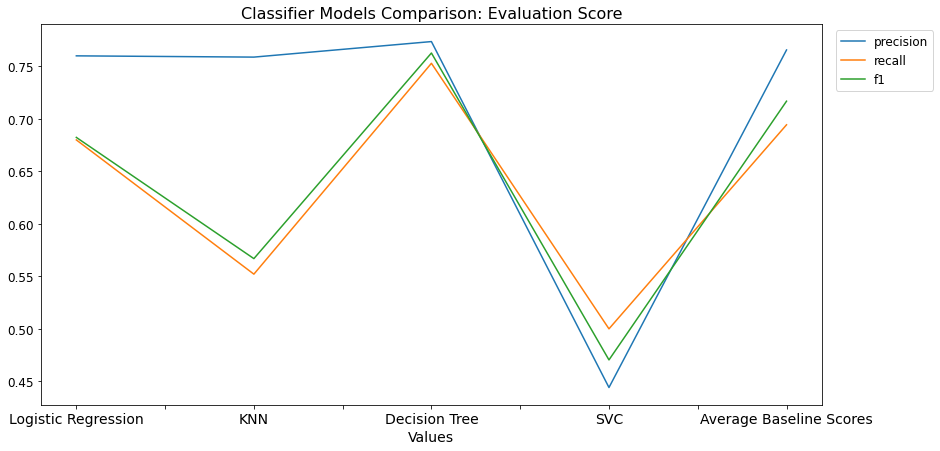

In [89]:
# 11 Visualizing Classifier Scores Comparison 

EVALGRID.drop(columns=['acc_train','acc_test','runtime(s)']).plot(kind='line',figsize=(14, 7))
plt.title('Classifier Models Comparison: Evaluation Score', fontsize=16)
plt.xlabel('Models', fontsize=14);plt.xlabel('Values', fontsize=14);
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left',fontsize=12);
plt.xticks(fontsize=14); plt.yticks(fontsize=12);plt.show()

 12. Models Performance comparison:

SVC is the most time consuming and computationally expensive of all models as demonstrated below.

It took ~25 minutes to run 2 iterations of SVC. While all other models ran ~16-20 iterations in least than 2 minutes.

Part of the bad score of the SVC is probably because I could not perform finetuning.

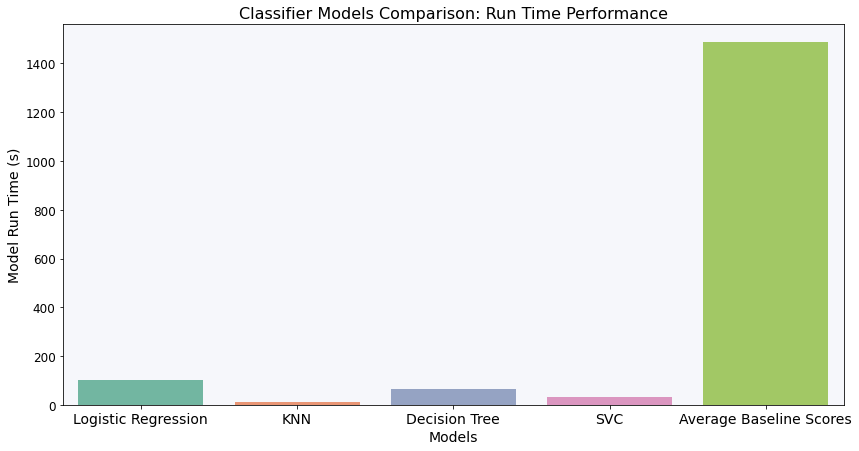

In [91]:
# 13 Visualizing Classifier Performance Comparison

runtimedf = EVALGRID[['runtime(s)']].T

plt.figure(figsize=(14,7)) 
graph = sns.barplot(data=runtimedf,palette='Set2')
plt.title('Classifier Models Comparison: Run Time Performance', fontsize=16)
plt.xlabel('Models', fontsize=14);plt.ylabel('Model Run Time (s)', fontsize=14); 
plt.xticks(fontsize=14); plt.yticks(fontsize=12);plt.gca().set_facecolor('#F6F7Fb')

 14. Feature Importance was arrived by ranking features by:
    
    * Chi Square statistical score 
    * Logistic Regression coefficient
    * Decision tree feature importance

I calculated the cumulative weighted ranking of all the ranking to get insights into the most important features

Interestingly the customer profile ends up being the most important predictor of the Marketing Campaign success.
Customers information like job info, housing & loan status and age see to be more telling of the chances of them making a Term Deposit than even the marketing campaign and prevailing economic situation.

This is intuitive if we think of assume the marketing campaign is already fairly standardized and optimized

The second tier of features that seem to be important are the marketing features like time, mode and frequency of communication.

Interestingly the month of the year seems to have an important bearing on the prediction. If the chances of success are high in particular months, it might be a good strategy to cyclically focus more on Term Deposit marketing in a particular periods of the year while focussing on other products during the other periods of the year.

In [92]:
featimp_display

,features,featurerank_log,featurerank_dec,featurerank_chi,weightedrank
0,client: job,1.0,1.0,3.0,1.0
3,client: age,4.0,4.0,NaN,2.0
1,client: housing,2.0,2.0,9.0,3.0
2,client: loan,3.0,5.0,10.0,4.0
6,mark:month,7.0,10.0,2.0,5.0
9,mark:contact,10.0,7.0,4.0,6.0
7,mark:contact day_of_week,8.0,6.0,8.0,7.0
12,mark:poutcome,13.0,11.0,1.0,8.5
5,client: default,6.0,14.0,5.0,8.5
16,client: education,17.0,3.0,6.0,10.0


 15. Dimensionality Reduction

Further I did a quick evaluation and I can confirm there is no difference in scores between the running the models with the original 5 economic features and with the 2 PCA features arrived by merging those features. This makes intutive sense since the PCA information retention is ~90%. While this specific problem set was not too big and contained only 21 features, this should a helpful pointer to leverage Dimensionality reduction in future on datasets with huge number of features

 16. Future Work

    * Do further deep dive into features that were deemed as important in this exercise
    * Perform further EDA & Feature engineering on Marketing Campaign features
    * Outlier removal resulted in loss of number of records with 'No' Client Response, which was already an underrepresented class. Future work can evaluate other ways of handling outliers